In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#pip install -U scikit-learn
#from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression

In [3]:
from sklearn import feature_selection
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [4]:
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
nome_arq = 'Dados Titanic -  IA.xlsx'

In [6]:
df = pd.read_excel(nome_arq)
df.head(3)

,Passageiro,Sobrevivente,Classe,Nome,Sexo,Idade,Irmãos,Pais,Tarifa
0,1,0,3,"Braund, Mr. Owen Harris",masculino,22.0,1,0,7.25
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",feminino,38.0,1,0,712833.00
2,3,1,3,"Heikkinen, Miss. Laina",feminino,26.0,0,0,7925.00


In [ ]:
#df['Sexo'] = df.Sexo.map({'masculino':0, 'feminino':1}).astype(int)

In [7]:
df_quant = pd.concat([df.iloc[:,:3], df.iloc[:,4:9]], axis=1)
df_quant.columns

Index(['Passageiro', 'Sobrevivente', 'Classe', 'Sexo', 'Idade', 'Irmãos',
       'Pais', 'Tarifa'],
      dtype='object')

In [8]:
Sexo = pd.get_dummies(df_quant.Sexo, drop_first=True)
df_quant.drop(columns='Sexo', inplace=True)
df_quant = pd.concat([df_quant, Sexo], axis= 1)

In [9]:
df_data = df_quant.drop(columns = 'Sobrevivente') # target
df_data.columns

Index(['Passageiro', 'Classe', 'Idade', 'Irmãos', 'Pais', 'Tarifa',
       'masculino'],
      dtype='object')

In [10]:
# target
y = df.iloc[:,1]
y_df = df[['Sobrevivente']]
y.name

'Sobrevivente'

## Análise de Correlação

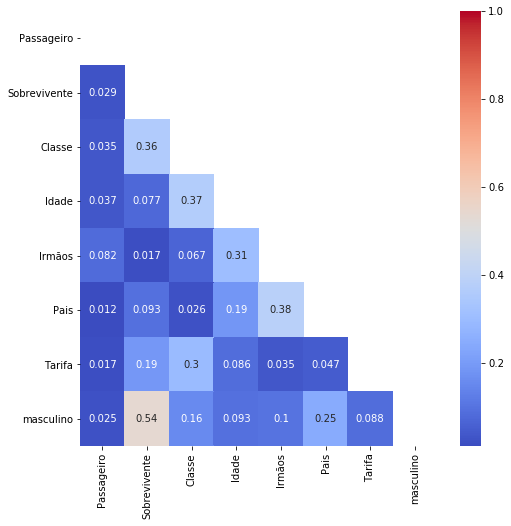

In [11]:
fig, ax = plt.subplots(figsize=(8, 8)) 
mask = np.zeros_like(df_quant.corr().abs())
mask[np.triu_indices_from(mask)] = 1
sns.heatmap(df_quant.corr().abs(), mask= mask, ax= ax, cmap='coolwarm', annot= True)

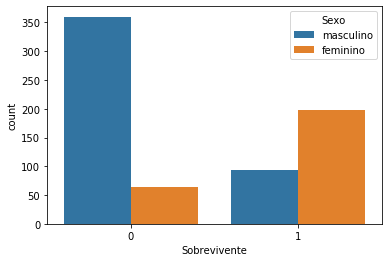

In [13]:
sns.countplot('Sobrevivente', hue = 'Sexo', data=df)

In [14]:
p_chance = pd.pivot_table(df, index=['Sexo'], values=['Passageiro'], columns=['Sobrevivente'], aggfunc=['count'])
chances = pd.DataFrame(p_chance.values, index=p_chance.index, columns=['s0','s1'])
chances['total'] = chances.sum(1)
chances['chance_1'] = chances.s1 / chances.s0
chances

,s0,s1,total,chance_1
Sexo,,,,
feminino,64,197,261,3.078125
masculino,360,93,453,0.258333


In [15]:
print(f"Chances (odds) de sobrevivência entre mulheres/homens = {chances.chance_1['feminino'] / chances.chance_1['masculino']}")

Chances (odds) de sobrevivência entre mulheres/homens = 11.91532258064516


In [16]:
X = df_data.values
y = y.values

In [17]:
# instanciar
lr = LogisticRegression()
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
F, p_value = feature_selection.f_regression(X, y)

In [19]:
print(f'Intercepto: {lr.intercept_}')

Intercepto: [-0.00041997]


In [20]:
def signif(p):
    if  p < 0.001: return '***'
    elif p < 0.01: return '**'
    elif p < 0.05: return '*'
    else: return 'not'

In [21]:
d_df = {'coef':list(lr.coef_[0]), 'F': list(F), 'p_value': list(p_value)}
dff = pd.DataFrame(d_df, index = df_data.columns)
#dff.loc[dff.p_value < 0.05, 'significativo'] = True
dff['significativo'] = dff['p_value'].map(signif)                  # aplica função a uma Series
dff['chance'] = pd.Series(np.exp(dff.coef.values), df_data.columns)
dff['1/chance'] = 1 / dff.chance
dff.sort_values(['F'], ascending=False, inplace=True)
dff

,coef,F,p_value,significativo,chance,1/chance
masculino,-0.001616,291.287485,5.224710e-55,***,0.998385,1.001618
Classe,-0.002304,105.779868,3.162104e-23,***,0.997699,1.002306
Tarifa,0.000002,26.773741,2.977531e-07,***,1.000002,0.999998
Pais,0.000189,6.254607,1.261065e-02,*,1.000189,0.999811
Idade,-0.019752,4.271195,3.912465e-02,*,0.980442,1.019948
Passageiro,0.000089,0.613450,4.337524e-01,not,1.000089,0.999911
Irmãos,-0.000333,0.214599,6.433277e-01,not,0.999667,1.000333


In [22]:
print(f'Score: {lr.score(X,y)}')

Score: 0.65406162464986


## Escolha das variáveis

In [23]:
colunas = ['masculino', 'Classe']
df_data = df_quant[colunas]
df_data.columns

Index(['masculino', 'Classe'], dtype='object')

In [24]:
X = df_data.values
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Confusion Matrix
* Termos associados à Confusion Matrix:
    * **Verdadeiro Positivo** (TP): Quando o valor observado é True e o modelo estima como True. Ou seja, o modelo acertou na estimativa.
        * Exemplo: O caso é uma Fraude e o modelo estima como Fraude.
    * **Verdadeiro Negativo** (TN): Quando o valor observado é False e o modelo estima como False. Ou seja, o modelo acertou na estimativa;
        * Exemplo: o caso é NÃO-Fraude e o modelo estima como NÃO-fraude;
    * **Falso Positivo** (FP): Quando o valor observado é False e o modelo estima como True. Ou seja, o modelo errou na estimativa. 
        * Exemplo: Um caso de Não-Fraude, mas o modelo estima como Fraude.
    * **Falso Negativo** (FN): Quando o valor observado é True e o modelo estima como False.
        * Exemplo: o caso é Fraude e o modelo estima como NÃO-Fraude.

* Consulte [Confusion matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)

![ConfusionMatrix](https://github.com/MathMachado/Materials/blob/master/ConfusionMatrix.PNG?raw=true)

Source: [Confusion Matrix](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781838555078/6/ch06lvl1sec34/confusion-matrix)

## Accuracy
> Accuracy - é o número de previsões corretas feitas pelo modelo.

Responde à seguinte pergunta:

```
Com que frequência o classificador classifica corretamente?
```

$$Accuracy= \frac{TP+TN}{TP+TN+FP+FN}$$

## Precision
> **Precision** - fornece informações sobre o desempenho em relação a Falsos Positivos (quantos capturamos).

Responde à seguinte pergunta:

```
Com relação ao resultado Positivo, com que frequência o classificador está correto?
```


$$Precision= \frac{TP}{TP+FP}$$

**Exemplo**: Precison nos dirá a proporção de clientes que o modelo estimou como sendo Fraude quando, na verdade, são fraude.

**Comentário**: Se nosso foco é minimizar Falso Negativos (FN), então precisamos nos esforçar para termos Recall próximo de 100%.

## Recall ou Sensitivity
> **Recall** - nos fornece informações sobre o desempenho de um classificador em relação a Falsos Negativos (quantos perdemos).

Responde à seguinte pergunta:

```
Quando o valor observado é Positivo, com que frequência o classificador está correto?
```

$$Recall = Sensitivity = \frac{TP}{TP+FN}$$

**Exemplo**: Recall é a proporção de clientes observados como Fraude e que o modelo estima como Fraude.

**Comentário**: Se nosso foco for minimizar Falso Positivos (FP), então precisamos nos esforçar para fazer Precision mais próximo de 100% possível.

## Specificity
> **Specificity** - proporção de TN por TN+FP.

Responde à seguinte pergunta:

```
Quando o valor observado é Negativo, com que frequência o classificador está correto?
```

**Exemplo**: Specificity é a proporção de clientes NÃO-Fraude que o modelo estima como NÃO-Fraude.

$$Specificity= \frac{TN}{TN+FP}$$

## F1-Score
> F1-Score é a média harmônica entre Recall e Precision e é um número entre 0 e 1. Quanto mais próximo de 1, melhor. Quanto mais próximo de 0, pior. Ou seja, é um equilíbrio entre Recall e Precision.

$$F1\_Score= 2\left(\frac{Recall*Precision}{Recall+Precision}\right)$$

Função para plotar a Confusion Matrix extraído de [Confusion Matrix Visualization](https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea)

In [25]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=False,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize= (8,8),
                          cmap='Blues'):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

In [26]:
nr_testes = 0

## Teste da acurácia com as Features

In [79]:
# valores preditos de y
y_pred = lr.predict(X)

In [80]:
print(f'r2: {metrics.r2_score(y, y_pred)}')

r2: 0.2044729993493818


In [81]:
F, p_value = feature_selection.f_regression(X, y)

In [82]:
print(f'Intercepto: {lr.intercept_}')

Intercepto: [5.38618934]


In [83]:
d_df = {'coef':list(lr.coef_[0]), 'F': list(F), 'p_value': list(p_value)}
dfr = pd.DataFrame(d_df, index = df_data.columns)
dfr['significativo'] = dfr['p_value'].map(signif)                  # aplica função a uma Series
dfr['chance'] = pd.Series(np.exp(dfr.coef.values), df_data.columns)
dfr['1/chance'] = 1 / dfr.chance
dfr

,coef,F,p_value,significativo,chance,1/chance
masculino,-2.500149,291.287485,5.224710e-55,***,0.082073,12.184310
Classe,-1.274194,105.779868,3.162104e-23,***,0.279656,3.575816
Idade,-0.043157,4.271195,3.912465e-02,*,0.957761,1.044102
Irmãos,-0.355041,0.214599,6.433277e-01,not,0.701144,1.426240


In [84]:
# coeficiente negativo: sexo masculino tem menos chance de sobrevivencia

In [85]:
# Accuracy = F-Score = lr.score(X,y)
d_df = {'Features': [colunas],'Accuracy':metrics.accuracy_score(y, y_pred), 'F1-Score': metrics.f1_score(y, y_pred)}
dfs = pd.DataFrame(d_df, index = ['score'])
dfs

,Features,Accuracy,F1-Score
score,"[masculino, Classe, Idade, Irmãos]",0.808123,0.755793


In [86]:
a_features0 = np.array([colunas, metrics.accuracy_score(y, y_pred), metrics.f1_score(y, y_pred)])

In [89]:
# Predição
lr.predict(np.array([[0,1,10,0]]))

array([1], dtype=int64)

In [92]:
# Probabilidade
lr.predict_proba(np.array([[0,1,10,0]]))

array([[0.02459222, 0.97540778]])

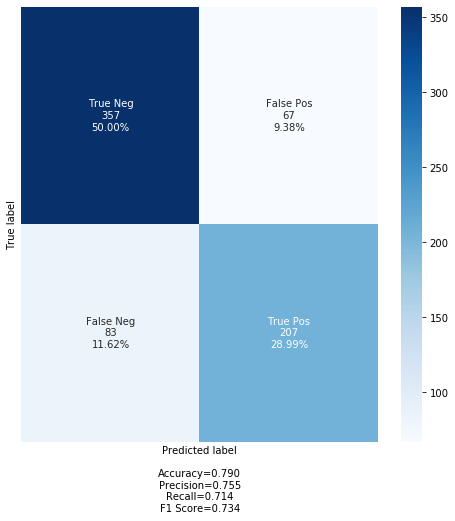

In [74]:
# Confusion Matrix
cf_matrix = confusion_matrix(y_df, y_pred)                    #  editar y_test e y_pred
cf_labels = ['True Neg','False Pos','False Neg','True Pos']
cf_categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, group_names= cf_labels, categories= cf_categories)

In [87]:
if nr_testes == 0: 
    a_features = a_features0
else:    
    a_features = np.append(a_features, np.array([colunas, metrics.accuracy_score(y, y_pred), metrics.f1_score(y, y_pred)]))

In [88]:
features = pd.DataFrame(a_features.reshape(int(a_features.shape[0]/3),3), columns = ['Features', 'Accuracy', 'F1-Score'])
nr_testes = features.shape[0]
features

,Features,Accuracy,F1-Score
0,"[masculino, Classe]",0.780112,0.715064
1,"[masculino, Classe, Tarifa]",0.413165,0.579739
2,"[masculino, Classe, Pais]",0.780112,0.715064
3,"[masculino, Classe, Idade]",0.789916,0.734043
4,"[masculino, Classe, Idade, Irmãos]",0.808123,0.755793


In [39]:
# Lista das features para teste
dff.sort_values(['F'], ascending=False)  # features

,coef,F,p_value,significativo,chance,1/chance
masculino,-0.001616,291.287485,5.224710e-55,***,0.998385,1.001618
Classe,-0.002304,105.779868,3.162104e-23,***,0.997699,1.002306
Tarifa,0.000002,26.773741,2.977531e-07,***,1.000002,0.999998
Pais,0.000189,6.254607,1.261065e-02,*,1.000189,0.999811
Idade,-0.019752,4.271195,3.912465e-02,*,0.980442,1.019948
Passageiro,0.000089,0.613450,4.337524e-01,not,1.000089,0.999911
Irmãos,-0.000333,0.214599,6.433277e-01,not,0.999667,1.000333


In [77]:
# Testes com outras features
colunas = ['masculino', 'Classe', 'Idade', 'Irmãos']
df_data = df_quant[colunas]
df_data.columns

Index(['masculino', 'Classe', 'Idade', 'Irmãos'], dtype='object')

In [78]:
X = df_data.values
lr.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
# repetir Teste da Acurácia para comparar resultados

In [ ]:
confusion_matrix = pd.crosstab(y, y_pred, rownames=['Actual'], colnames=['Predicted'])

In [ ]:
sns.heatmap(confusion_matrix, annot=True)